In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader


In [ ]:
# For reproducability
torch.manual_seed(311)

In [2]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(64),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(64),
        #transforms.CenterCrop(64),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [3]:
image_datasets = {
    'train': datasets.ImageFolder('Final_Data_Reduced/Train', data_transforms['train']),
    'val': datasets.ImageFolder('Final_Data_Reduced/Validation', data_transforms['val'])
}

In [4]:
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

In [5]:
class ASLClassifierCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = torch.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ASLClassifierCNN(num_classes=27).to(device)


In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    print("Training complete!")

# Train the model
train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

In [15]:
def train_model_with_hyperparameters(num_classes, learning_rate, batch_size, num_epochs):
    # Instantiate model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = ASLClassifierCNN(num_classes=num_classes).to(device)

    # Dataloaders with specified batch size
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
        'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)
    }

    # Define Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 20)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for i, (inputs, labels) in enumerate(dataloaders[phase]):
                print(f"Processing batch {i+1}/{len(dataloaders[phase])} for {phase} phase")
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    print("Training complete!")

# Example usage of the function
train_model_with_hyperparameters(num_classes=27, learning_rate=0.001, batch_size=32, num_epochs=10)

Epoch 1/10
--------------------
Processing batch 1/175 for train phase
Processing batch 2/175 for train phase
Processing batch 3/175 for train phase
Processing batch 4/175 for train phase
Processing batch 5/175 for train phase
Processing batch 6/175 for train phase
Processing batch 7/175 for train phase
Processing batch 8/175 for train phase
Processing batch 9/175 for train phase
Processing batch 10/175 for train phase
Processing batch 11/175 for train phase
Processing batch 12/175 for train phase
Processing batch 13/175 for train phase
Processing batch 14/175 for train phase
Processing batch 15/175 for train phase
Processing batch 16/175 for train phase
Processing batch 17/175 for train phase
Processing batch 18/175 for train phase
Processing batch 19/175 for train phase
Processing batch 20/175 for train phase
Processing batch 21/175 for train phase
Processing batch 22/175 for train phase
Processing batch 23/175 for train phase
Processing batch 24/175 for train phase
Processing batch 

RuntimeError: Caught RuntimeError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 211, in collate
    return [
           ^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 212, in <listcomp>
    collate(samples, collate_fn_map=collate_fn_map)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/_utils/collate.py", line 272, in collate_tensor_fn
    return torch.stack(batch, 0, out=out)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: stack expects each tensor to be equal size, but got [3, 256, 256] at entry 0 and [3, 512, 513] at entry 3


Training with hyperparameters: {'num_classes': 27, 'learning_rate': 0.001, 'batch_size': 32}
Epoch 1/3
--------------------
Train Batch 1/175 - Loss: 3.2885, Accuracy: 0.0938
Train Batch 2/175 - Loss: 5.4133, Accuracy: 0.0938
Train Batch 3/175 - Loss: 3.7957, Accuracy: 0.0000
Train Batch 4/175 - Loss: 3.3291, Accuracy: 0.0312
Train Batch 5/175 - Loss: 3.2687, Accuracy: 0.0312
Train Batch 6/175 - Loss: 3.3380, Accuracy: 0.0000
Train Batch 7/175 - Loss: 3.2943, Accuracy: 0.0312
Train Batch 8/175 - Loss: 3.2773, Accuracy: 0.1250
Train Batch 9/175 - Loss: 3.2490, Accuracy: 0.1562
Train Batch 10/175 - Loss: 3.2384, Accuracy: 0.0625
Train Batch 11/175 - Loss: 3.2556, Accuracy: 0.0625
Train Batch 12/175 - Loss: 3.5009, Accuracy: 0.0000
Train Batch 13/175 - Loss: 3.2601, Accuracy: 0.0625
Train Batch 14/175 - Loss: 3.2908, Accuracy: 0.0000
Train Batch 15/175 - Loss: 3.3498, Accuracy: 0.0000
Train Batch 16/175 - Loss: 3.2770, Accuracy: 0.0312
Train Batch 17/175 - Loss: 3.2930, Accuracy: 0.0625
T

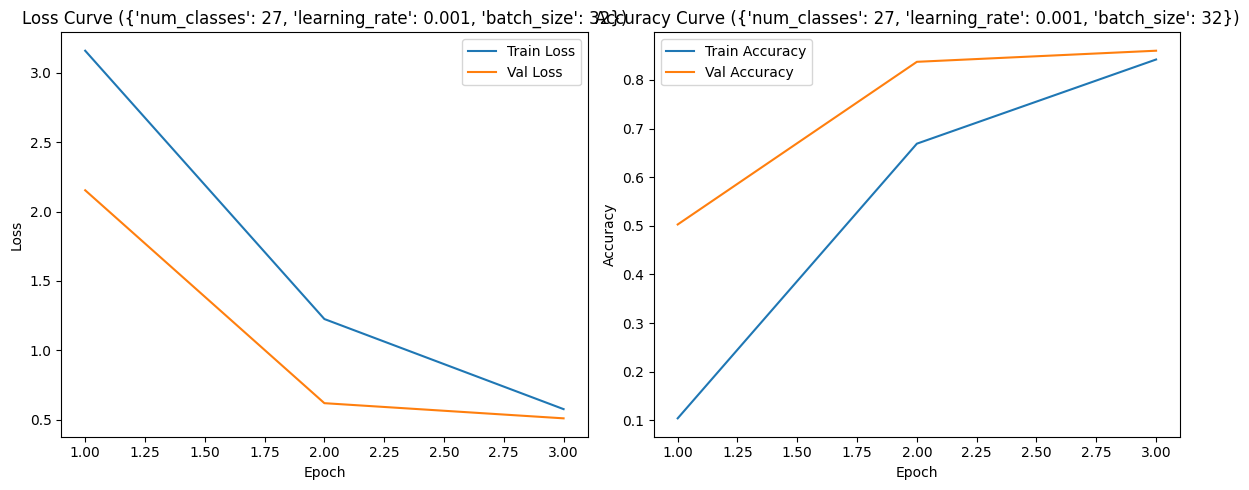

NameError: name 'confusion_matrix' is not defined

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

def train_and_plot_hyperparameter_effects(hyperparameters, image_datasets, num_epochs=10):
    """
    Trains the model with different hyperparameter combinations and plots results.

    Args:
        hyperparameters (list of dict): List of hyperparameter dictionaries.
        image_datasets (dict): Datasets for 'train' and 'val' datasets.
        num_epochs (int): Number of epochs for each training run.

    Returns:
        pd.DataFrame: A DataFrame with hyperparameter configurations and corresponding results.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []

    for config in hyperparameters:
        print(f"Training with hyperparameters: {config}")

        # Extract hyperparameters
        num_classes = config.get('num_classes', 27)
        learning_rate = config.get('learning_rate', 0.001)
        batch_size = config.get('batch_size', 32)

        # Initialize model, criterion, optimizer
        model = ASLClassifierCNN(num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Update dataloaders for the current batch size
        dataloaders = {
            'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=4),
            'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=4)
        }

        train_losses, val_losses = [], []
        train_accs, val_accs = [], []
        best_val_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print('-' * 20)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []

                for i, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs, labels = inputs.to(device), labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += labels.size(0)

                    batch_loss = loss.item()
                    batch_acc = torch.sum(preds == labels.data).double() / labels.size(0)

                    print(f"{phase.capitalize()} Batch {i+1}/{len(dataloaders[phase])} - Loss: {batch_loss:.4f}, Accuracy: {batch_acc:.4f}")

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects.double() / total_samples

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accs.append(epoch_acc.item())
                else:
                    val_losses.append(epoch_loss)
                    val_accs.append(epoch_acc.item())

                    # Check if the model improved
                    if epoch_acc > best_val_acc:
                        best_val_acc = epoch_acc
                        torch.save(model.state_dict(), 'best_model.pth')
                        print(f"Saved best model at epoch {epoch+1}")

                print(f"{phase.capitalize()} Epoch Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        # Save results for this configuration
        results.append({
            'config': config,
            'train_loss': train_losses[-1],
            'val_loss': val_losses[-1],
            'train_acc': train_accs[-1],
            'val_acc': val_accs[-1]
        })

        # Plot learning curves for this configuration
        plt.figure(figsize=(12, 5))

        # Loss Curve
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
        plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f"Loss Curve ({config})")
        plt.legend()

        # Accuracy Curve
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs + 1), train_accs, label='Train Accuracy')
        plt.plot(range(1, num_epochs + 1), val_accs, label='Val Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f"Accuracy Curve ({config})")
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Plot confusion matrix for validation set
        if len(all_preds) > 0 and len(all_labels) > 0:
            cm = confusion_matrix(all_labels, all_preds)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.title(f'Confusion Matrix ({config})')
            plt.show()

    # Convert results to a DataFrame for further analysis
    results_df = pd.DataFrame(results)
    print("All configurations completed!")
    return results_df


# Example of hyperparameter configurations to test
hyperparameter_configs = [
    {'num_classes': 27, 'learning_rate': 0.001, 'batch_size': 32},
    {'num_classes': 27, 'learning_rate': 0.0005, 'batch_size': 64},
    {'num_classes': 27, 'learning_rate': 0.005, 'batch_size': 16},
]

# Run training and plot results
results_df = train_and_plot_hyperparameter_effects(hyperparameter_configs, image_datasets, num_epochs=3)

# Display summary results
print(results_df)